## Imports

In [12]:
import os
import h5py
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dropout, BatchNormalization, Dense, GlobalAveragePooling1D, TimeDistributed, MaxPooling1D, Flatten
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from parse_data import load_intra_train, load_intra_test, load_cross_train, load_cross_test

## Constants

In [19]:
DOWNSAMPLING_STEP = 8
NUM_CLASSES = 4
BATCH_SIZE = 3

ENCODE_MAP = {
        'rest': 0,
        'motor': 1,
        'memory': 2,
        'math': 3,
    }

INTRA_OR_CROSS_MODE = "cross"

if INTRA_OR_CROSS_MODE == "cross":
    load_train = load_cross_train
    load_test = load_cross_test
elif INTRA_OR_CROSS_MODE == "intra":
    load_train = load_intra_train
    load_test = load_intra_test


## Load data

In [ ]:
X_train, y_train = load_train(batch_size=BATCH_SIZE,downsample_step=DOWNSAMPLING_STEP,logs=True)

X.shape from Data\Cross\train: (94976, 3, 248)


## LSTM Model only

In [15]:
time_steps = X_train.shape[1]
num_channels = X_train.shape[2]

if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lstm_model = Sequential([
    TimeDistributed(Dense(64, kernel_regularizer=l2(1e-4)), input_shape=(time_steps, num_channels)),

    LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(128, kernel_regularizer=l2(1e-3)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation='softmax')
])


lstm_model.compile(optimizer=Nadam(learning_rate=1e-6),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


In [16]:
history = lstm_model.fit(
    X_train, y_train,   
    epochs=15,
    batch_size=64,
    validation_split=0.5,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
742/742 [==============================] - 28s 23ms/step - loss: 1.6311 - accuracy: 0.2646 - val_loss: 1.6029 - val_accuracy: 0.6135
Epoch 2/15
742/742 [==============================] - 14s 19ms/step - loss: 1.5725 - accuracy: 0.4796 - val_loss: 1.5317 - val_accuracy: 0.6920
Epoch 3/15
742/742 [==============================] - 16s 22ms/step - loss: 1.5124 - accuracy: 0.6137 - val_loss: 1.4669 - val_accuracy: 0.7489
Epoch 4/15
742/742 [==============================] - 14s 19ms/step - loss: 1.4484 - accuracy: 0.6786 - val_loss: 1.3990 - val_accuracy: 0.7542
Epoch 5/15
742/742 [==============================] - 16s 21ms/step - loss: 1.3804 - accuracy: 0.7172 - val_loss: 1.3256 - val_accuracy: 0.7707
Epoch 6/15
742/742 [==============================] - 17s 24ms/step - loss: 1.3091 - accuracy: 0.7431 - val_loss: 1.2482 - val_accuracy: 0.7832
Epoch 7/15
742/742 [==============================] - 16s 21ms/step - loss: 1.2334 - accuracy: 0.7622 - val_loss: 1.1688 - val_accuracy:

# Training Progress

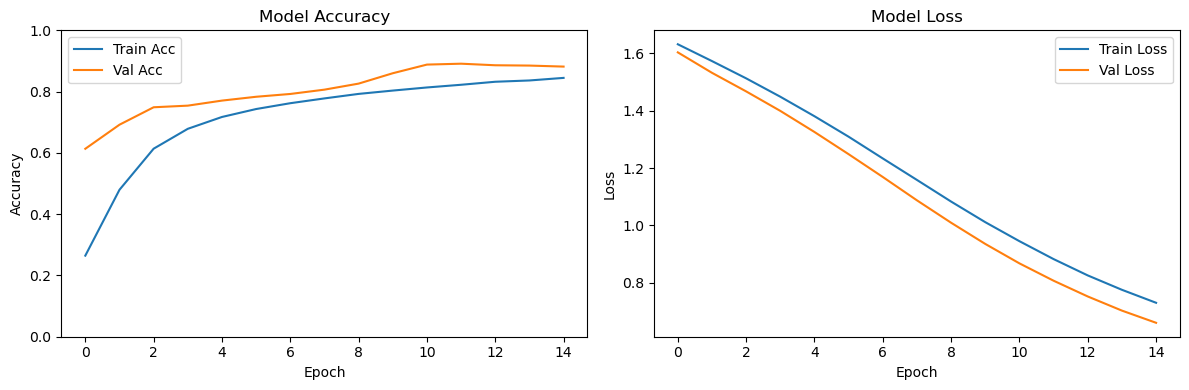

In [17]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Testing & Evaluating

In [20]:
# Load and preprocess test data
X_test, y_test = load_test(batch_size=BATCH_SIZE,downsample_step=DOWNSAMPLING_STEP,logs=1)

# One-hot encode labels
y_test = to_categorical(y_test, num_classes=4)

Loading from test1
X.shape from Data\Cross\test1: (23744, 3, 248)
Loading from test2
X.shape from Data\Cross\test2: (23744, 3, 248)
Loading from test3
X.shape from Data\Cross\test3: (23744, 3, 248)


In [21]:
# Evaluate
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy:", test_acc)

2226/2226 [==============================] - 9s 4ms/step - loss: 1.5144 - accuracy: 0.5409
Test accuracy: 0.5408805012702942


2226/2226 [==============================] - 9s 4ms/step


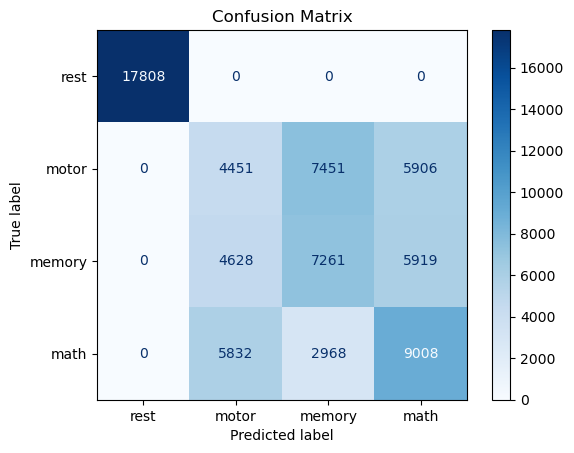

In [22]:
# Predict class probabilities
y_pred_probs = lstm_model.predict(X_test)
# Convert one-hot back to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["rest", "motor", "memory", "math"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
